# Enter State Farm

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [2]:
%matplotlib inline
from __future__ import print_function, division
path = "data/nantes_tiles/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using Theano backend.


In [3]:
batch_size=64

## Setup batches

In [8]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 8364 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [5]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 8364 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 0 images belonging to 1 classes.


Rather than using batches, we could just import all the data into an array to save some processing time. (In most examples I'm using the batches, however - just because that's how I happened to start out.)

In [6]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 8364 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [8]:
save_array(path+'results/val.dat', val)
save_array(path+'results/trn.dat', trn)

In [4]:
val = load_array(path+'results/val.dat')
trn = load_array(path+'results/trn.dat')

## Re-run sample experiments on full dataset

We should find that everything that worked on the sample (see statefarm-sample.ipynb), works on the full dataset too. Only better! Because now we have more data. So let's see how they go - the models in this section are exact copies of the sample notebook models.

### Single conv layer

In [9]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [10]:
model = conv1(batches)

Epoch 1/2
8364/8364 [==============================] - 107s - loss: 0.3796 - acc: 0.8575 - val_loss: 0.7062 - val_acc: 0.6181
Epoch 2/2
8364/8364 [==============================] - 99s - loss: 0.1249 - acc: 0.9550 - val_loss: 0.5047 - val_acc: 0.7650
Epoch 1/4
8364/8364 [==============================] - 106s - loss: 0.0565 - acc: 0.9809 - val_loss: 0.2590 - val_acc: 0.8944
Epoch 2/4
8364/8364 [==============================] - 99s - loss: 0.0381 - acc: 0.9885 - val_loss: 0.2292 - val_acc: 0.9125
Epoch 3/4
8364/8364 [==============================] - 99s - loss: 0.0289 - acc: 0.9915 - val_loss: 0.2435 - val_acc: 0.9231
Epoch 4/4
8364/8364 [==============================] - 98s - loss: 0.0147 - acc: 0.9969 - val_loss: 0.2122 - val_acc: 0.9313


Interestingly, with no regularization or augmentation we're getting some reasonable results from our simple convolutional model. So with augmentation, we hopefully will see some very good results.

In [48]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 8364 images belonging to 2 classes.


In [49]:
model = conv1(batches)

Epoch 1/2
8364/8364 [==============================] - 106s - loss: 0.4678 - acc: 0.8091 - val_loss: 0.6168 - val_acc: 0.6850
Epoch 2/2
8364/8364 [==============================] - 98s - loss: 0.2936 - acc: 0.8868 - val_loss: 0.4660 - val_acc: 0.8375
Epoch 1/4
8364/8364 [==============================] - 104s - loss: 0.2513 - acc: 0.9023 - val_loss: 0.3295 - val_acc: 0.8706
Epoch 2/4
8364/8364 [==============================] - 98s - loss: 0.2401 - acc: 0.9081 - val_loss: 0.2448 - val_acc: 0.9019
Epoch 3/4
8364/8364 [==============================] - 99s - loss: 0.2127 - acc: 0.9204 - val_loss: 0.2068 - val_acc: 0.9250
Epoch 4/4
8364/8364 [==============================] - 99s - loss: 0.2085 - acc: 0.9203 - val_loss: 0.2178 - val_acc: 0.9163


### Validate predictions

In [20]:
probs = model.predict_generator(val_batches, val_batches.nb_sample)
# conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)
# conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [19]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(our_predictions)

In [20]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/' + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [21]:
val_batches.class_indices

{'north': 0, 'south': 1}

[[725  75]
 [ 68 732]]


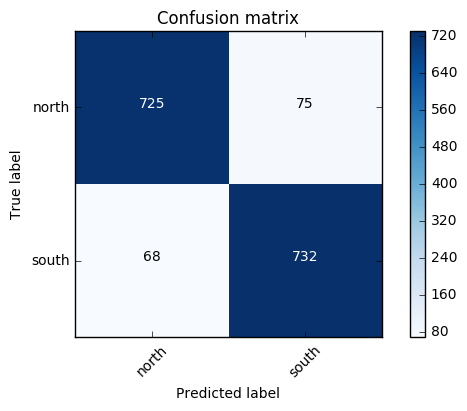

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

### Data augmentation

In [60]:
model.optimizer.lr = 0.0001
model.fit_generator(batches, batches.nb_sample, nb_epoch=15, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/15
8364/8364 [==============================] - 104s - loss: 0.1984 - acc: 0.9242 - val_loss: 0.1786 - val_acc: 0.9331
Epoch 2/15
8364/8364 [==============================] - 98s - loss: 0.1935 - acc: 0.9285 - val_loss: 0.1927 - val_acc: 0.9281
Epoch 3/15
8364/8364 [==============================] - 100s - loss: 0.1772 - acc: 0.9311 - val_loss: 0.1826 - val_acc: 0.9300
Epoch 4/15
8364/8364 [==============================] - 99s - loss: 0.1815 - acc: 0.9296 - val_loss: 0.2014 - val_acc: 0.9287
Epoch 5/15
8364/8364 [==============================] - 102s - loss: 0.1684 - acc: 0.9347 - val_loss: 0.2008 - val_acc: 0.9300
Epoch 6/15
8364/8364 [==============================] - 102s - loss: 0.1592 - acc: 0.9375 - val_loss: 0.1676 - val_acc: 0.9387
Epoch 7/15
8364/8364 [==============================] - 102s - loss: 0.1640 - acc: 0.9379 - val_loss: 0.1615 - val_acc: 0.9419
Epoch 8/15
8364/8364 [==============================] - 104s - loss: 0.1494 - acc: 0.9415 - val_loss: 0.1574 - va

In [63]:
model.save_weights(path+'weights_augmentation_and_finer_lr.h5')

In [14]:
model.load_weights(path+'weights_augmentation_and_finer_lr.h5')

In [15]:
probs = model.predict_generator(val_batches, val_batches.nb_sample)

[[725  75]
 [ 68 732]]


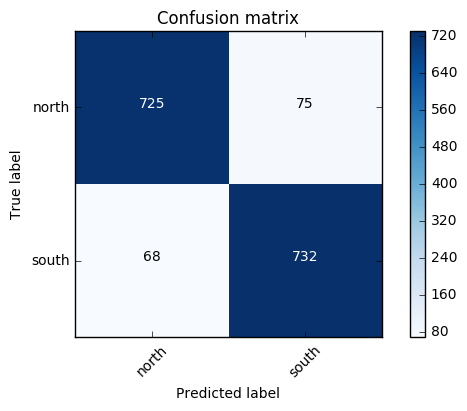

In [23]:
#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(our_predictions)
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

Found 1457 correct labels


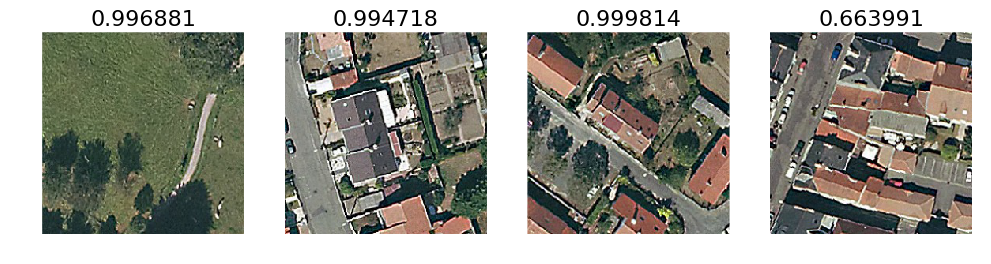

In [24]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print ("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 253 incorrect labels


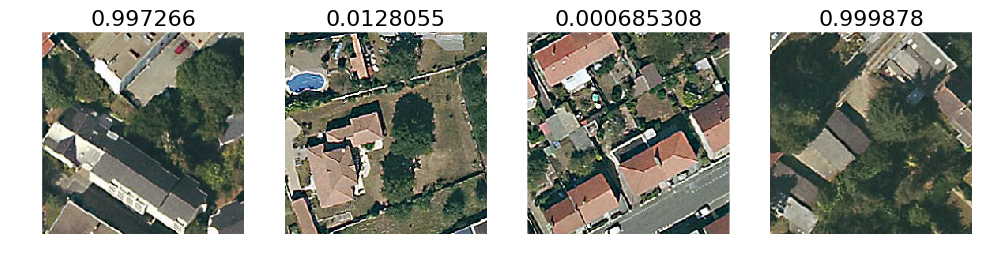

In [101]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 725 confident correct north labels


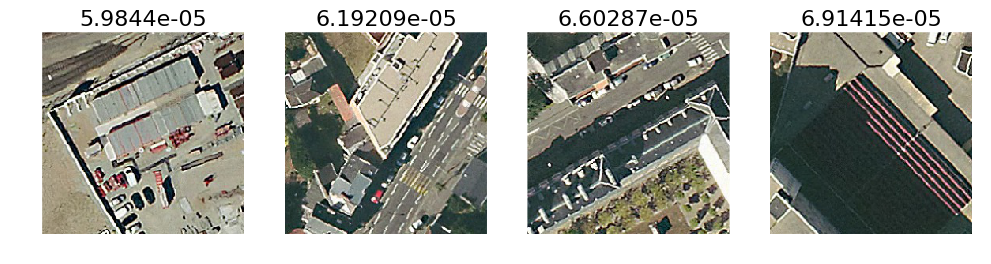

In [42]:
#3a. The images we most confident were north, and are actually north
correct_north = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print ("Found %d confident correct north labels" % len(correct_north))
most_correct_north = np.argsort(our_predictions[correct_north])[8:12]
plots_idx(correct_north[most_correct_north], our_predictions[correct_north][most_correct_north])

Found 732 confident correct south labels


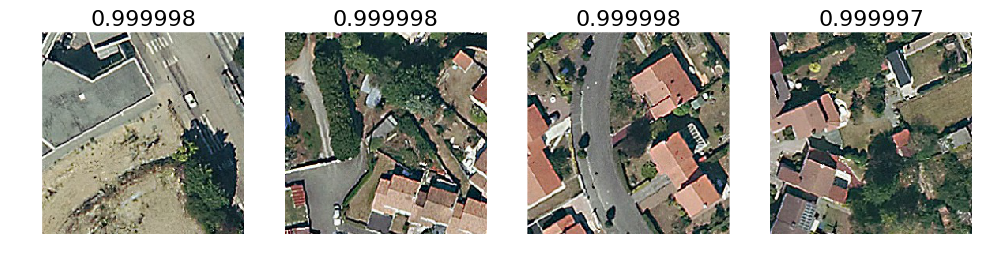

In [45]:
#3b. The images we most confident were south, and are actually south
correct_south = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print ("Found %d confident correct south labels" % len(correct_south))
most_correct_south = np.argsort(our_predictions[correct_south])[::-1][8:12]
plots_idx(correct_south[most_correct_south], our_predictions[correct_south][most_correct_south])

Found 68 incorrect north


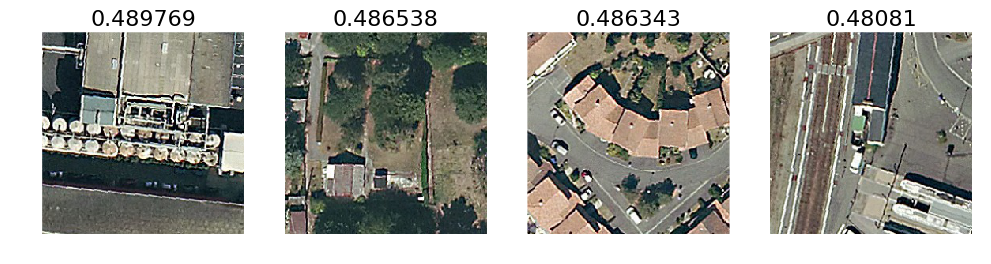

In [27]:
#4a. The images we were most confident were north, but are actually south
incorrect_north = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect north" % len(incorrect_north))
if len(incorrect_north):
    most_incorrect_north = np.argsort(our_predictions[incorrect_north])[::-1][:n_view]
    plots_idx(incorrect_north[most_incorrect_north], our_predictions[incorrect_north][most_incorrect_north])

Found 75 incorrect south


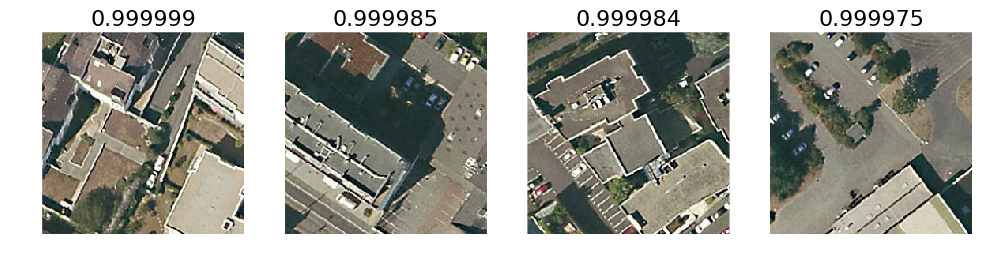

In [28]:
#4b. The images we were most confident were south, but are actually north
incorrect_south = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect south" % len(incorrect_south))
if len(incorrect_south):
    most_incorrect_south = np.argsort(our_predictions[incorrect_south])[::-1][:n_view]
    plots_idx(incorrect_south[most_incorrect_south], our_predictions[incorrect_south][most_incorrect_south])

I'm shocked by *how* good these results are! We're regularly seeing 75-80% accuracy on the validation set, which puts us into the top third or better of the competition. With such a simple model and no dropout or semi-supervised learning, this really speaks to the power of this approach to data augmentation.

## Show tile coordinates

In [279]:
probs_on_train = model.predict_generator(batches, batches.nb_sample)
our_predictions_on_train = probs_on_train[:,0]

In [31]:
train_filenames = batches.filenames

In [32]:
import re

# np.column_stack((filenames, our_predictions))
pattern = re.compile(".*\/(\d+)_(\d+)\.jpg")
all_x = []
all_y = []
for filename in train_filenames:
    matches = pattern.search(filename)
    all_x.append(int(matches.group(1)))
    all_y.append(int(matches.group(2)))

    
# all_x
x_min = np.min(all_x)
x_max = np.max(all_x)
y_min = np.min(all_y)
y_max = np.max(all_y)
x_max-x_min

93

(151, 93)

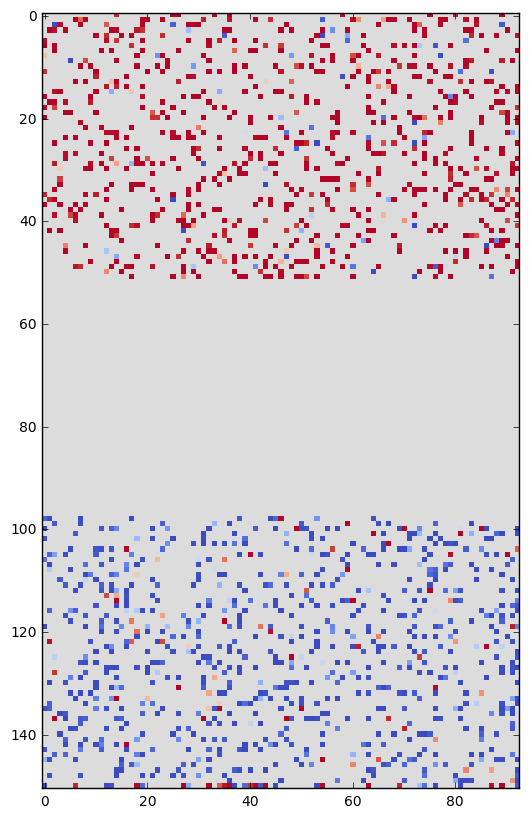

In [33]:
from matplotlib import cm


heatmap = np.full([y_max-y_min, x_max-x_min], .5)
# points = np.column_stack((train_filenames, our_predictions_on_train))
points = np.column_stack((filenames, our_predictions))
pattern = re.compile(".*\/(\d+)_(\d+)\.jpg")
for point in points:
    matches = pattern.search(point[0])
    i = int(matches.group(2))-y_min-1
    j = int(matches.group(1))-x_min-1
    heatmap[i,j] = point[1]
#     print("X : %d, Y : %d" % (int(matches.group(1))-x_min, int(matches.group(2))-y_min))


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(heatmap, interpolation='nearest', cmap=cm.coolwarm)

heatmap.shape

### Four conv/pooling pairs + dropout

Unfortunately, the results are still very unstable - the validation accuracy jumps from epoch to epoch. Perhaps a deeper model with some dropout would help.

In [20]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 18946 images belonging to 10 classes.


In [21]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(128,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

In [22]:
model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
18946/18946 [==============================] - 159s - loss: 2.6578 - acc: 0.2492 - val_loss: 1.8681 - val_acc: 0.3844
Epoch 2/2
18946/18946 [==============================] - 158s - loss: 1.8098 - acc: 0.4334 - val_loss: 1.3152 - val_acc: 0.5670


In [24]:
model.optimizer.lr=0.001

In [25]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=10, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/10
18946/18946 [==============================] - 159s - loss: 1.4232 - acc: 0.5405 - val_loss: 1.0877 - val_acc: 0.6452
Epoch 2/10
18946/18946 [==============================] - 159s - loss: 1.1155 - acc: 0.6346 - val_loss: 1.2730 - val_acc: 0.6878
Epoch 3/10
18946/18946 [==============================] - 159s - loss: 0.9043 - acc: 0.7025 - val_loss: 1.1393 - val_acc: 0.6354
Epoch 4/10
18946/18946 [==============================] - 159s - loss: 0.7444 - acc: 0.7529 - val_loss: 1.1037 - val_acc: 0.7087
Epoch 5/10
18946/18946 [==============================] - 159s - loss: 0.6299 - acc: 0.7955 - val_loss: 0.9123 - val_acc: 0.7455
Epoch 6/10
18946/18946 [==============================] - 159s - loss: 0.5220 - acc: 0.8275 - val_loss: 1.0418 - val_acc: 0.7484
Epoch 7/10
18946/18946 [==============================] - 159s - loss: 0.4686 - acc: 0.8495 - val_loss: 1.2907 - val_acc: 0.6599
Epoch 8/10
18946/18946 [==============================] - 159s - loss: 0.4190 - acc: 0.8653 - val

In [26]:
model.optimizer.lr=0.00001

In [27]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=10, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/10
18946/18946 [==============================] - 159s - loss: 0.3183 - acc: 0.8976 - val_loss: 1.0359 - val_acc: 0.7688
Epoch 2/10
18946/18946 [==============================] - 158s - loss: 0.2788 - acc: 0.9109 - val_loss: 1.5806 - val_acc: 0.6705
Epoch 3/10
18946/18946 [==============================] - 158s - loss: 0.2810 - acc: 0.9124 - val_loss: 0.9836 - val_acc: 0.7887
Epoch 4/10
18946/18946 [==============================] - 158s - loss: 0.2403 - acc: 0.9244 - val_loss: 1.1832 - val_acc: 0.7493
Epoch 5/10
18946/18946 [==============================] - 159s - loss: 0.2195 - acc: 0.9303 - val_loss: 1.1524 - val_acc: 0.7510
Epoch 6/10
18946/18946 [==============================] - 159s - loss: 0.2085 - acc: 0.9359 - val_loss: 1.2245 - val_acc: 0.7415
Epoch 7/10
18946/18946 [==============================] - 158s - loss: 0.1961 - acc: 0.9399 - val_loss: 1.1232 - val_acc: 0.7654
Epoch 8/10
18946/18946 [==============================] - 158s - loss: 0.1851 - acc: 0.9416 - val

This is looking quite a bit better - the accuracy is similar, but the stability is higher. There's still some way to go however...

### Imagenet conv features

Since we have so little data, and it is similar to imagenet images (full color photos), using pre-trained VGG weights is likely to be helpful - in fact it seems likely that we won't need to fine-tune the convolutional layer weights much, if at all. So we can pre-compute the output of the last convolutional layer, as we did in lesson 3 when we experimented with dropout. (However this means that we can't use full data augmentation, since we can't pre-compute something that changes every image.)

In [14]:
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [15]:
conv_model = Sequential(conv_layers)

In [ ]:
# batches shuffle must be set to False when pre-computing features
batches = get_batches(path+'train', batch_size=batch_size, shuffle=False)

In [16]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 18946 images belonging to 10 classes.
Found 3478 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [ ]:
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [ ]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_test_feat.dat', conv_test_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [10]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
conv_val_feat.shape

(3478, 512, 14, 14)

### Batchnorm dense layers on pretrained conv layers

Since we've pre-computed the output of the last convolutional layer, we need to create a network that takes that as input, and predicts our 10 classes. Let's try using a simplified version of VGG's dense layers.

In [71]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [72]:
p=0.8

In [73]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 18946 samples, validate on 3478 samples
Epoch 1/1
18946/18946 [==============================] - 3s - loss: 1.5894 - acc: 0.5625 - val_loss: 0.7031 - val_acc: 0.7522


In [75]:
bn_model.optimizer.lr=0.01

In [76]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 18946 samples, validate on 3478 samples
Epoch 1/2
18946/18946 [==============================] - 3s - loss: 0.2870 - acc: 0.9109 - val_loss: 0.7728 - val_acc: 0.7683
Epoch 2/2
18946/18946 [==============================] - 3s - loss: 0.1422 - acc: 0.9594 - val_loss: 0.7576 - val_acc: 0.7936


In [77]:
bn_model.save_weights(path+'models/conv8.h5')

Looking good! Let's try pre-computing 5 epochs worth of augmented data, so we can experiment with combining dropout and augmentation on the pre-trained model.

### Pre-computed data augmentation + dropout

We'll use our usual data augmentation parameters:

In [107]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
da_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

Found 18946 images belonging to 10 classes.


We use those to create a dataset of convolutional features 5x bigger than the training set.

In [108]:
da_conv_feat = conv_model.predict_generator(da_batches, da_batches.nb_sample*5)

In [109]:
save_array(path+'results/da_conv_feat2.dat', da_conv_feat)

In [78]:
da_conv_feat = load_array(path+'results/da_conv_feat2.dat')

Let's include the real training data as well in its non-augmented form.

In [131]:
da_conv_feat = np.concatenate([da_conv_feat, conv_feat])

Since we've now got a dataset 6x bigger than before, we'll need to copy our labels 6 times too.

In [132]:
da_trn_labels = np.concatenate([trn_labels]*6)

Based on some experiments the previous model works well, with bigger dense layers.

In [210]:
def get_bn_da_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [216]:
p=0.8

In [240]:
bn_model = Sequential(get_bn_da_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Now we can train the model as usual, with pre-computed augmented data.

In [241]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 113676 samples, validate on 3478 samples
Epoch 1/1
113676/113676 [==============================] - 16s - loss: 1.5848 - acc: 0.5068 - val_loss: 0.6340 - val_acc: 0.8131


In [242]:
bn_model.optimizer.lr=0.01

In [243]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 113676 samples, validate on 3478 samples
Epoch 1/4
113676/113676 [==============================] - 16s - loss: 0.6652 - acc: 0.7785 - val_loss: 0.6343 - val_acc: 0.8082
Epoch 2/4
113676/113676 [==============================] - 16s - loss: 0.5247 - acc: 0.8318 - val_loss: 0.6951 - val_acc: 0.8085
Epoch 3/4
113676/113676 [==============================] - 16s - loss: 0.4553 - acc: 0.8544 - val_loss: 0.6067 - val_acc: 0.8189
Epoch 4/4
113676/113676 [==============================] - 16s - loss: 0.4127 - acc: 0.8686 - val_loss: 0.7701 - val_acc: 0.7915


In [244]:
bn_model.optimizer.lr=0.0001

In [245]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 113676 samples, validate on 3478 samples
Epoch 1/4
113676/113676 [==============================] - 16s - loss: 0.3837 - acc: 0.8775 - val_loss: 0.6904 - val_acc: 0.8197
Epoch 2/4
113676/113676 [==============================] - 16s - loss: 0.3576 - acc: 0.8872 - val_loss: 0.6593 - val_acc: 0.8209
Epoch 3/4
113676/113676 [==============================] - 16s - loss: 0.3384 - acc: 0.8939 - val_loss: 0.7057 - val_acc: 0.8085
Epoch 4/4
113676/113676 [==============================] - 16s - loss: 0.3254 - acc: 0.8977 - val_loss: 0.6867 - val_acc: 0.8128


Looks good - let's save those weights.

In [246]:
bn_model.save_weights(path+'models/da_conv8_1.h5')

### Pseudo labeling

We're going to try using a combination of [pseudo labeling](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf) and [knowledge distillation](https://arxiv.org/abs/1503.02531) to allow us to use unlabeled data (i.e. do semi-supervised learning). For our initial experiment we'll use the validation set as the unlabeled data, so that we can see that it is working without using the test set. At a later date we'll try using the test set.

To do this, we simply calculate the predictions of our model...

In [247]:
val_pseudo = bn_model.predict(conv_val_feat, batch_size=batch_size)

...concatenate them with our training labels...

In [255]:
comb_pseudo = np.concatenate([da_trn_labels, val_pseudo])

In [256]:
comb_feat = np.concatenate([da_conv_feat, conv_val_feat])

...and fine-tune our model using that data.

In [257]:
bn_model.load_weights(path+'models/da_conv8_1.h5')

In [258]:
bn_model.fit(comb_feat, comb_pseudo, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 117154 samples, validate on 3478 samples
Epoch 1/1
117154/117154 [==============================] - 17s - loss: 0.3412 - acc: 0.8948 - val_loss: 0.7653 - val_acc: 0.8191


In [259]:
bn_model.fit(comb_feat, comb_pseudo, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 117154 samples, validate on 3478 samples
Epoch 1/4
117154/117154 [==============================] - 17s - loss: 0.3237 - acc: 0.9008 - val_loss: 0.7536 - val_acc: 0.8229
Epoch 2/4
117154/117154 [==============================] - 17s - loss: 0.3076 - acc: 0.9050 - val_loss: 0.7572 - val_acc: 0.8235
Epoch 3/4
117154/117154 [==============================] - 17s - loss: 0.2984 - acc: 0.9085 - val_loss: 0.7852 - val_acc: 0.8269
Epoch 4/4
117154/117154 [==============================] - 17s - loss: 0.2902 - acc: 0.9117 - val_loss: 0.7630 - val_acc: 0.8263


In [260]:
bn_model.optimizer.lr=0.00001

In [261]:
bn_model.fit(comb_feat, comb_pseudo, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 117154 samples, validate on 3478 samples
Epoch 1/4
117154/117154 [==============================] - 17s - loss: 0.2837 - acc: 0.9134 - val_loss: 0.7901 - val_acc: 0.8200
Epoch 2/4
117154/117154 [==============================] - 17s - loss: 0.2760 - acc: 0.9155 - val_loss: 0.7648 - val_acc: 0.8275
Epoch 3/4
117154/117154 [==============================] - 17s - loss: 0.2723 - acc: 0.9183 - val_loss: 0.7382 - val_acc: 0.8358
Epoch 4/4
117154/117154 [==============================] - 17s - loss: 0.2657 - acc: 0.9191 - val_loss: 0.7227 - val_acc: 0.8329


That's a distinct improvement - even although the validation set isn't very big. This looks encouraging for when we try this on the test set.

In [262]:
bn_model.save_weights(path+'models/bn-ps8.h5')

### Submit

We'll find a good clipping amount using the validation set, prior to submitting.

In [271]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

In [282]:
keras.metrics.categorical_crossentropy(val_labels, do_clip(val_preds, 0.93)).eval()

array(0.6726388006592667)

In [283]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [284]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)

In [285]:
subm = do_clip(preds,0.93)

In [305]:
subm_name = path+'results/subm.gz'

In [296]:
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [301]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_68347.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.093739,0.815874,0.079049,0.007778
1,img_55725.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778
2,img_92799.jpg,0.007778,0.930000,0.017918,0.007778,0.007778,0.007778,0.009022,0.007778,0.007778,0.007778
3,img_72170.jpg,0.007778,0.007778,0.363869,0.007778,0.007778,0.007778,0.200521,0.007778,0.425176,0.007778
4,img_59154.jpg,0.695756,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.047384,0.249183


In [307]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [308]:
FileLink(subm_name)

/data/jhoward/fast-image/nbs/data/state/results/subm.gz

This gets 0.534 on the leaderboard.

## The "things that didn't really work" section

You can safely ignore everything from here on, because they didn't really help.

### Finetune some conv layers too

In [28]:
for l in get_bn_layers(p): conv_model.add(l)

In [29]:
for l1,l2 in zip(bn_model.layers, conv_model.layers[last_conv_idx+1:]):
    l2.set_weights(l1.get_weights())

In [30]:
for l in conv_model.layers: l.trainable =False

In [31]:
for l in conv_model.layers[last_conv_idx+1:]: l.trainable =True

In [36]:
comb = np.concatenate([trn, val])

In [37]:
gen_t = image.ImageDataGenerator(rotation_range=8, height_shift_range=0.04, 
                shear_range=0.03, channel_shift_range=10, width_shift_range=0.08)

In [38]:
batches = gen_t.flow(comb, comb_pseudo, batch_size=batch_size)

Exception: X (images tensor) and y (labels) should have the same length. Found: X.shape = (22424, 3, 224, 224), y.shape = (98208, 10)

In [176]:
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 3478 images belonging to 10 classes.


In [177]:
conv_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [178]:
conv_model.fit_generator(batches, batches.N, nb_epoch=1, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/1
22400/22424 [============================>.] - ETA: 0s - loss: 0.4348 - acc: 0.9200

MemoryError: Error allocating 1644167168 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAllocEmpty(Shape_i{0}.0, Shape_i{0}.0, Elemwise{Composite{(((i0 - i1) // i2) + i2)}}[(0, 1)].0, Elemwise{Composite{(((i0 - i1) // i2) + i2)}}[(0, 1)].0)
Toposort index: 157
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(128), array(64), array(224), array(224)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='valid', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
conv_model.optimizer.lr = 0.0001

In [ ]:
conv_model.fit_generator(batches, batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

In [ ]:
for l in conv_model.layers[16:]: l.trainable =True

In [ ]:
conv_model.optimizer.lr = 0.00001

In [ ]:
conv_model.fit_generator(batches, batches.N, nb_epoch=8, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

In [ ]:
conv_model.save_weights(path+'models/conv8_ps.h5')

In [77]:
conv_model.load_weights(path+'models/conv8_da.h5')

In [135]:
val_pseudo = conv_model.predict(val, batch_size=batch_size*2)

In [159]:
save_array(path+'models/pseudo8_da.dat', val_pseudo)

### Ensembling

In [14]:
drivers_ds = pd.read_csv(path+'driver_imgs_list.csv')
drivers_ds.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [15]:
img2driver = drivers_ds.set_index('img')['subject'].to_dict()

In [16]:
driver2imgs = {k: g["img"].tolist() 
               for k,g in drivers_ds[['subject', 'img']].groupby("subject")}

In [56]:
def get_idx(driver_list):
    return [i for i,f in enumerate(filenames) if img2driver[f[3:]] in driver_list]

In [17]:
drivers = driver2imgs.keys()

In [94]:
rnd_drivers = np.random.permutation(drivers)

In [95]:
ds1 = rnd_drivers[:len(rnd_drivers)//2]
ds2 = rnd_drivers[len(rnd_drivers)//2:]

In [68]:
models=[fit_conv([d]) for d in drivers]
models=[m for m in models if m is not None]

In [77]:
all_preds = np.stack([m.predict(conv_test_feat, batch_size=128) for m in models])
avg_preds = all_preds.mean(axis=0)
avg_preds = avg_preds/np.expand_dims(avg_preds.sum(axis=1), 1)

In [102]:
keras.metrics.categorical_crossentropy(val_labels, np.clip(avg_val_preds,0.01,0.99)).eval()

array(0.9753041572894531)

In [103]:
keras.metrics.categorical_accuracy(val_labels, np.clip(avg_val_preds,0.01,0.99)).eval()

array(0.6949396133422852, dtype=float32)